In [1]:
import os
import numpy as np
import pandas as pd
import json

# Experiment results

The experiment was based on the classical POMDP problem - Tiger problem. 

### Tiger Problem

In the problem setting, there are two doors and a tiger. In each run of the problem, the tiger is initialized randomly behind one door and is unknown to the player. The player could take three possible actions for each step - listen, open door 1 and open door 2.
    
    - Listen: by listening, player will heard a sound from either door 1 or 2. However the origin of sound is not guaranteed correct. Listening action results in a tiny cost to player (-1)
    - Open door 1/2: by opening one door, player enters the exit state with either a large reward (+10) if the tiger doesn't stand behind the door, or a even larger penalty (-20) otherwise.
    
    
### Experiment method

The experiment programs the Tiger problem setting and the agent using "Linear Value Function Approximation" solving the POMDP. We also added choices of applying three kinds of deceptive mask onto player's observations - 'opposite', 'random', 'probabilistic', together with the original observation model.

 - Original observation model(baseline): player has a higher probability (0.85) to hear the true origin of tiger's sound and small chance to hear it wrongly. i.e. [True, False] = [0.85, 0.15]

 - 'opposite' mask gives opposite observation from true origin of the sound. [True, False] = [0, 1]

 - 'random' mask gives randomly generated observation and is impartial to two doors. [True, False] = [0.5, 0.5]

 -  'probabilistic' mask provides a relatively "less correct" observation compared to original. [True, False] = [0.6, 0.6]
 
Baseline experiment and experiment with 'random' mask was run twice; experiment with 'opposite' and 'probabilistic' mask was run 4 times respectively.

During each 'run', the Tiger problem was played 5000 times; the agent was trained every 9 from 10 epochs and the rest was test epoch. During the test epoch, we records the player's action taken, observation and reward received for every step.


## Direct results from experiment

For the below experiments, the average undiscounted/discounted return/step results are:

- Baseline: 
    - run 1 - undiscounted: 4.90 +- 0.30, discounted: 4.42 +- 0.28
    - run 2 - undiscounted: 4.69 +- 0.33, discounted: 4.41 +- 0.31

- "Opposite":
    - run 1 - undiscounted: -20.47 +- 0.10, discounted: -19.50 +- 0.00
    - run 2 - undiscounted: -20.47 +- 0.10, discounted: -19.50 +- 0.10
    - run 3 - undiscounted: -20.91 +- 0.12, discounted: -19.49 +- 0.10
    - run 4 - undiscounted: -20.47 +- 0.10, discounted: -19.49 +- 0.10
    
- "Random":
    - run 1 - undiscounted: -9.96 +- 0.54, discounted: -7.61 +- 0.42
    - run 2 - undiscounted: -9.57 +- 0.55, discounted: -7.14 +- 0.42

- "Probabilistic" ($p_{correct} = 0.6$):
    - run 1 - undiscounted: -2.51 +- 0.32, discounted: -2.39 +- 0.30
    - run 2 - undiscounted: -3.69 +- 0.33, discounted: -3.53 +- 0.30
    - run 3 - undiscounted: -2.58 +- 0.32, discounted: -2.47 +- 0.30
    - run 4 - undiscounted: -3.01 +- 0.33, discounted: -2.91 +- 0.31

### Look into the stepwise results

We further look into the stepwise outcome for each epoch in each run of experiments.

We parse the verbal records into numerical statistics. Below are related codes, jump to:
   
   - [link to data processing](#processing)
   - [link to results](#results)
for analysis.



In [2]:
def parse(path):
    results = dict()
    
    with open(path, 'r', encoding='utf-8') as f:
        content = f.readlines()
    if not content:
        raise ValueError("path not valid")
    temp_epoch = -1
    temp_block = dict()
    temp_step = -1
    temp_reward = 0
    for line in content:
        line = line.strip()
        if len(line)==0:
            temp_block['r'] = temp_reward
            if 'fr' not in temp_block:
                temp_block['fr'] = temp_reward
            if temp_epoch==5000 and len(temp_block)==1:
                break
            results[temp_epoch] = temp_block
            
            # renew the temps
            temp_block = dict()
            temp_reward = 0
        elif line[:3]=='eva':
            temp_epoch = int(line.strip('.').split(' ')[-1])
            #print(temp_epoch)
        elif line[:2]=='b ':
            line = line.split(' ')
            temp_step = int(line[1])
            b1 = float(line[2].strip('['))
            b2 = float(line[3].strip(']'))
            temp_block[temp_step] = (b1, b2)
            #print(temp_step, b1, b2)
        elif line[20:23]=='Rew':
            temp_v = float(line.split(' ')[-1])
            if temp_v != -1.0:
                temp_block['fr'] = temp_v
            temp_reward += temp_v
            
    results.pop(-1, None)
    return results

In [3]:
path = './temp/'

oppo_fn = ['oppo1', 'oppo2', 'oppo3', 'oppo4']
prob_fn = ['prob1_60','prob2_60','prob3_60','prob1_60']
rand_fn = ['rand1', 'rand2']
valid_fn = ['valid', 'valid2']

In [4]:
def save_json(file_list):
    for fn in file_list:
        res = parse(path+fn+'.txt')
        with open(path+fn+'.json', 'w') as fp:
            json.dump(res, fp)
    print("Json saved.")

In [5]:
save_json(oppo_fn)
save_json(prob_fn)
save_json(rand_fn)
save_json(valid_fn)

Json saved.
Json saved.
Json saved.
Json saved.


In [6]:
def get_stat(res_dict):
    belief_stat = dict()
    reward_stat = dict()
    for _, epoch in res_dict.items():
        for k,v in epoch.items():
            if k == 'r':
                if v in reward_stat:
                    reward_stat[v] += 1
                else:
                    reward_stat[v] = 1
            else:
                if v[0] in belief_stat:
                    belief_stat[v[0]] += 1
                else:
                    belief_stat[v[0]] = 1
                    
    return belief_stat, reward_stat

def get_stat_count(res_dict):
    b1_all = []
    for _, epoch in res_dict.items():
        for k,v in epoch.items():
            if k != 'r' and k != 'fr':
                b1_all.append(v) 
    return b1_all

def get_belief_reward(res_dict):
    b1_rwds = []
    fr_stat = dict()
    for k, epoch in res_dict.items():
        temp_rew = epoch.pop('r')
        temp_fr = epoch.pop('fr')
        if temp_fr in fr_stat:
            fr_stat[temp_fr] += 1
        else:
            fr_stat[temp_fr] = 1
        for bs in epoch.values():
            b1_rwds.append((bs[0], temp_rew))
    return b1_rwds, fr_stat

In [7]:
import matplotlib.pyplot as plt
from functools import reduce

<a id='processing'></a>

### Explanation

I collect the believes of the player from every step of every testing, together with the resulting rewards at the final step - the exit state which marks whether the player successfully avoid the hazard or not. By combining the belief in the process with the final rewards, we aim to analyze how the rewards distribute over belief.

### baseline with no deceptive mask

Run 1 have -20.0 in 41 results; 10.0 in 459 results; 0 in 1 results; 
Run 2 have 10.0 in 435 results; -20.0 in 65 results; 0 in 1 results; 


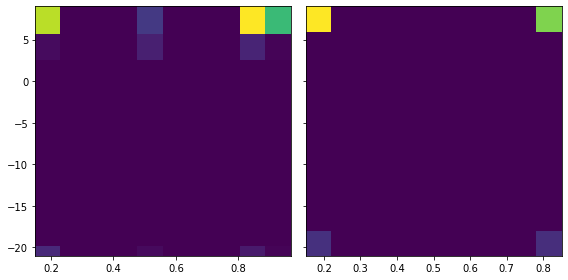

In [8]:
_, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8,4))
valid_b1_rew = []
for i in range(len(valid_fn)):
    temp_res = parse(path+valid_fn[i]+'.txt')
    b1_rew, fr_stat = get_belief_reward(temp_res)
    msg = "Run {} have "+'{} in {} results; '*len(fr_stat)
    print(msg.format(i+1, *list(reduce(lambda x, y: x + y, fr_stat.items()))))
    valid_b1_rew += b1_rew
    b1_rew = np.asarray(b1_rew)
    axs[i].hist2d(b1_rew[:, 0], b1_rew[:, 1], bins=10)

### baseline with opposite mask

Run 1 have -20.0 in 500 results; 0 in 1 results; 
Run 2 have -20.0 in 500 results; 0 in 1 results; 
Run 3 have -20.0 in 499 results; -50.0 in 1 results; 0 in 1 results; 
Run 4 have -20.0 in 500 results; 0 in 1 results; 


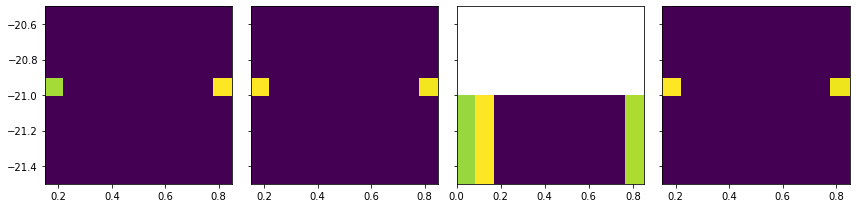

In [9]:
_, axs = plt.subplots(1, len(oppo_fn), sharey=True, tight_layout=True, figsize=(12,3))
oppo_b1_rew = []
for i in range(len(oppo_fn)):
    temp_res = parse(path+oppo_fn[i]+'.txt')
    b1_rew, fr_stat = get_belief_reward(temp_res)
    msg = "Run {} have "+'{} in {} results; '*len(fr_stat)
    print(msg.format(i+1, *list(reduce(lambda x, y: x + y, fr_stat.items()))))
    oppo_b1_rew += b1_rew
    b1_rew = np.asarray(b1_rew)
    axs[i].hist2d(b1_rew[:, 0], b1_rew[:, 1], bins=10)

### baseline with probabilistic deceptive mask

Run 1 have -20.0 in 376 results; 10.0 in 623 results; -50.0 in 1 results; 0 in 1 results; 
Run 2 have -20.0 in 373 results; 10.0 in 627 results; 0 in 1 results; 
Run 3 have 10.0 in 613 results; -20.0 in 386 results; -50.0 in 1 results; 0 in 1 results; 
Run 4 have -20.0 in 376 results; 10.0 in 623 results; -50.0 in 1 results; 0 in 1 results; 


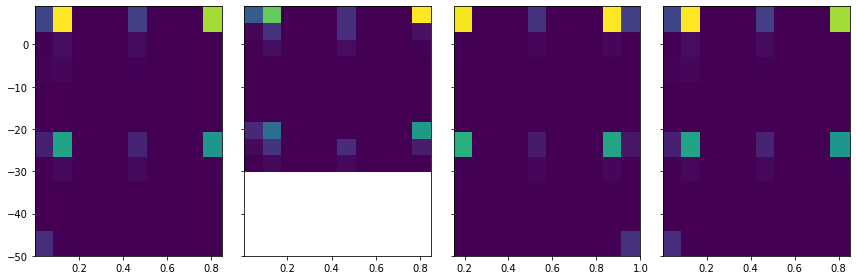

In [10]:
_, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(12,4))
prob_b1_rew = []
for i in range(len(prob_fn)):
    temp_res = parse(path+prob_fn[i]+'.txt')
    b1_rew, fr_stat = get_belief_reward(temp_res)
    msg = "Run {} have "+'{} in {} results; '*len(fr_stat)
    print(msg.format(i+1, *list(reduce(lambda x, y: x + y, fr_stat.items()))))
    prob_b1_rew += b1_rew
    b1_rew = np.asarray(b1_rew)
    axs[i].hist2d(b1_rew[:, 0], b1_rew[:, 1], bins=10)

### baseline with random mask

Run 1 have 10.0 in 244 results; -20.0 in 239 results; -50.0 in 17 results; 0 in 1 results; 
Run 2 have 10.0 in 245 results; -20.0 in 239 results; -50.0 in 16 results; 0 in 1 results; 


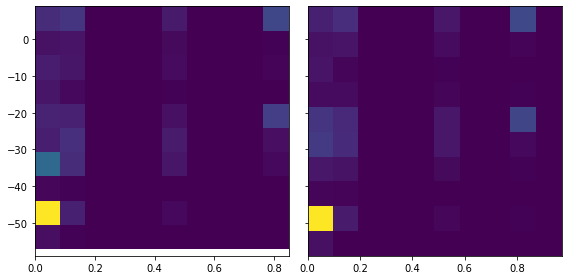

In [11]:
_, axs = plt.subplots(1, len(rand_fn), sharey=True, tight_layout=True, figsize=(8,4))
rand_b1_rew= []
for i in range(len(rand_fn)):
    temp_res = parse(path+rand_fn[i]+'.txt')
    b1_rew, fr_stat = get_belief_reward(temp_res)
    msg = "Run {} have "+'{} in {} results; '*len(fr_stat)
    print(msg.format(i+1, *list(reduce(lambda x, y: x + y, fr_stat.items()))))
    rand_b1_rew += b1_rew
    b1_rew = np.asarray(b1_rew)
    axs[i].hist2d(b1_rew[:, 0], b1_rew[:, 1], bins=10)

### Aggregate the results from 4 settings and cross comparing

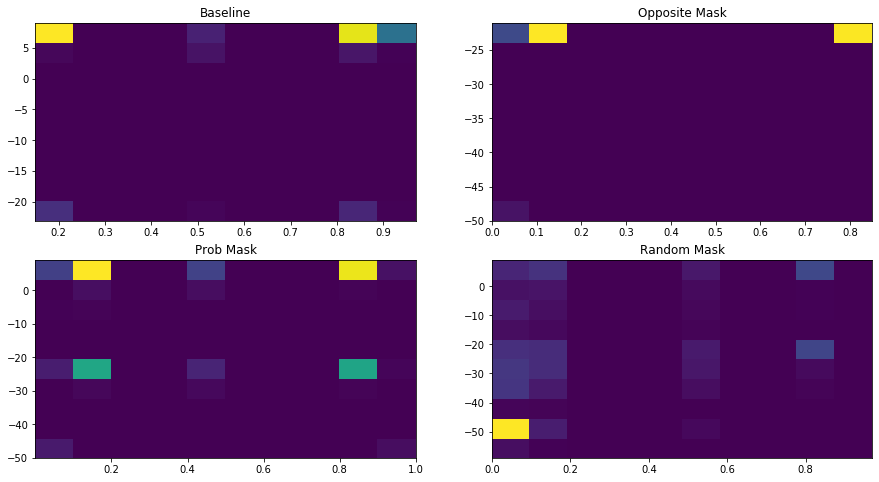

In [12]:
#_, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(12,3))

valid_b1_rew = np.asarray(valid_b1_rew)
oppo_b1_rew = np.asarray(oppo_b1_rew)
prob_b1_rew = np.asarray(prob_b1_rew)
rand_b1_rew = np.asarray(rand_b1_rew)

fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.title.set_text('Baseline')
ax2.title.set_text('Opposite Mask')
ax3.title.set_text('Prob Mask')
ax4.title.set_text('Random Mask')

_ = ax1.hist2d(valid_b1_rew[:, 0], valid_b1_rew[:, 1], bins=10)
_ = ax2.hist2d(oppo_b1_rew[:, 0], oppo_b1_rew[:, 1], bins=10)
_ = ax3.hist2d(prob_b1_rew[:, 0], prob_b1_rew[:, 1], bins=10)
_ = ax4.hist2d(rand_b1_rew[:, 0], rand_b1_rew[:, 1], bins=10)

<a id='results'></a>
## Results

As shown in statistical results, for baseline model with no deception on observation, the agent achieves success (away from tiger) with approximate 90% probability.

When applying probabilistic deceptive mask with 0.6 correct rate, the success rate of the player drops to 62.3%.

When applying randomly deceptive mask, the success rate drops to 50% approximately. This makes sense because the tiger is initialized randomly and impartially behind two doors. Applying random mask is mathematically equivalent to making random guess from two doors.

When applying opposite mask, the player won't survive a single attempt.

### Regarding the distribution of resulting rewards over belief, 
we see that "opposite" mask serves as a quick and direct deception - the player will simply listen once, get a falsified observation and make wrong selection of the door. It's a short "pain" for the player with no success chance.

The "random" mask deceives the player in another approach. The player still wins at almost 50% chance, which equals to random guess. However, in many runs of the model, the player suffered from "long pain" when they repeatedly tried to listen for the correct sound and yet get puzzled by the falsified feedback generated by random mask. Some runs resulted in an even worse reward/penalty than an direct fail as small costs of listening aggregate large. Some player eventually made max number of steps allowed (50) and was forced to exit.

The "probabilistic" mask works as a "subtle" deception. The distribution of final rewards resembles the one from baseline, yet the player has less chance to success in the end.

### histogram 1D - belief for door 1

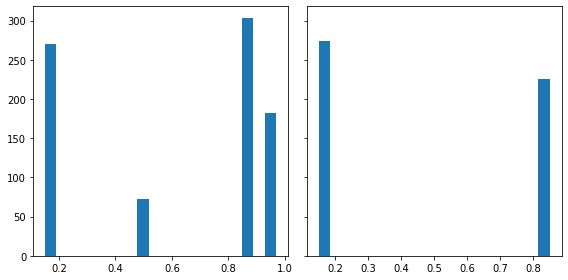

In [13]:
_, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(8,4))

for i in range(len(valid_fn)):
    temp_res = parse(path+valid_fn[i]+'.txt')
    temp_b1 = np.asarray(get_stat_count(temp_res))
    axs[i].hist(temp_b1[:, 0], bins=20)

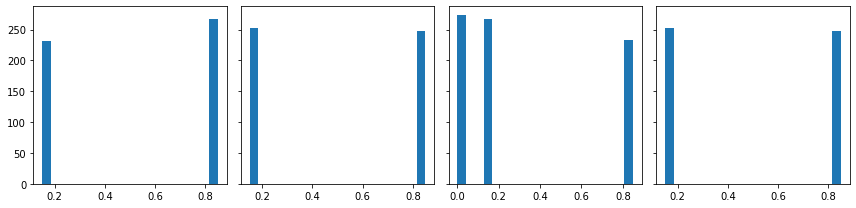

In [14]:
_, oppo_ax = plt.subplots(1, len(oppo_fn), sharey=True, tight_layout=True, figsize=(12,3))
for i in range(len(oppo_fn)):
    temp_res = parse(path+oppo_fn[i]+'.txt')
    temp_belief_1 = np.asarray(get_stat_count(temp_res))
    oppo_ax[i].hist(temp_belief_1[:,0], bins=20)

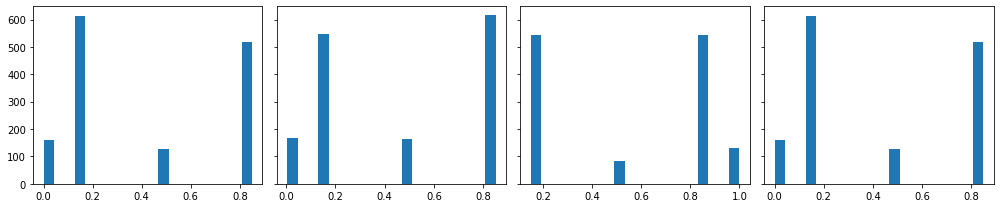

In [15]:
_, prob_ax = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(14,3))
for i in range(len(prob_fn)):
    temp_res = parse(path+prob_fn[i]+'.txt')
    temp_belief_1 = np.asarray(get_stat_count(temp_res))
    prob_ax[i].hist(temp_belief_1[:,0], bins=20)

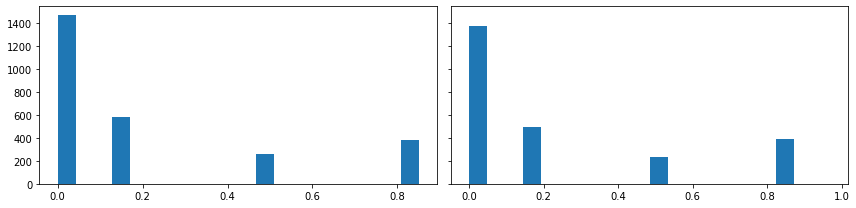

In [16]:
_, rand_ax = plt.subplots(1, len(rand_fn), sharey=True, tight_layout=True, figsize=(12,3))
for i in range(len(rand_fn)):
    temp_res = parse(path+rand_fn[i]+'.txt')
    temp_belief_1 = np.asarray(get_stat_count(temp_res))
    rand_ax[i].hist(temp_belief_1[:,0], bins=20)

In [17]:
# Plot alpha vectors
from experiments.scripts import plot_alpha_vectors
from experiments.scripts import pickle_wrapper
import os

  [*] load ./experiments\pickle_jar\console.pkl
   [-] load_pkl : 1.10929 sec


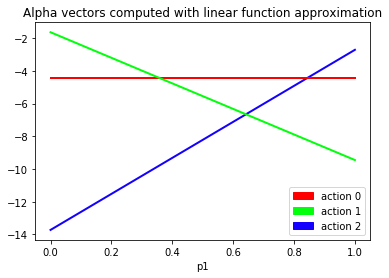

  [*] load ./experiments\pickle_jar\console2.pkl
   [-] load_pkl : 0.00000 sec


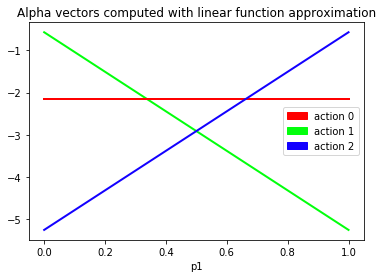

In [18]:
n_actions = 3

weight_dir = os.path.join('./experiments', 'pickle_jar')

valid_pkl = ['console.pkl', 'console2.pkl']
for pkl in valid_pkl:
    gamma = pickle_wrapper.load_pkl(os.path.join(weight_dir, pkl))

    plot_alpha_vectors.plot_alpha_vectors('Alpha vectors computed with linear function approximation', gamma, n_actions)

  [*] load ./experiments\pickle_jar\oppo1.pkl
   [-] load_pkl : 0.00000 sec


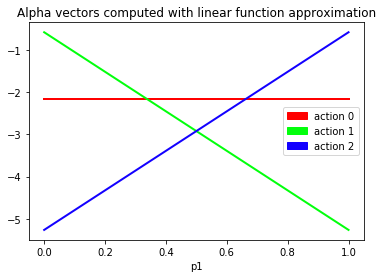

  [*] load ./experiments\pickle_jar\oppo2.pkl
   [-] load_pkl : 0.00000 sec


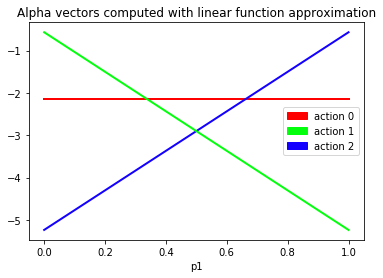

  [*] load ./experiments\pickle_jar\oppo3.pkl
   [-] load_pkl : 0.00000 sec


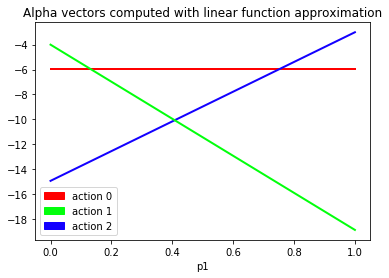

  [*] load ./experiments\pickle_jar\oppo4.pkl
   [-] load_pkl : 0.00000 sec


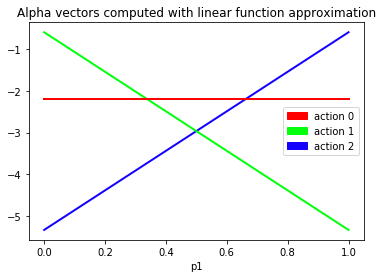

In [19]:
for oppo in oppo_fn:
    gamma = pickle_wrapper.load_pkl(os.path.join(weight_dir, oppo+'.pkl'))

    plot_alpha_vectors.plot_alpha_vectors('Alpha vectors computed with linear function approximation', gamma, n_actions)

  [*] load ./experiments\pickle_jar\rand1.pkl
   [-] load_pkl : 0.00100 sec


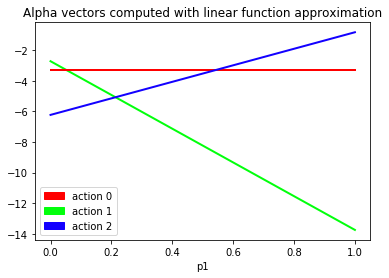

  [*] load ./experiments\pickle_jar\rand2.pkl
   [-] load_pkl : 0.00000 sec


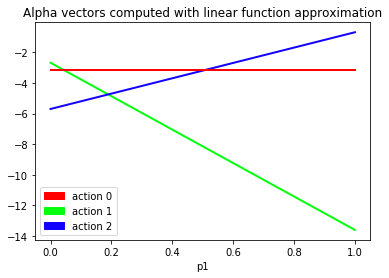

In [20]:
for rand in rand_fn:
    gamma = pickle_wrapper.load_pkl(os.path.join(weight_dir, rand+'.pkl'))

    plot_alpha_vectors.plot_alpha_vectors('Alpha vectors computed with linear function approximation', gamma, n_actions)

  [*] load ./experiments\pickle_jar\prob1_60.pkl
   [-] load_pkl : 0.00000 sec


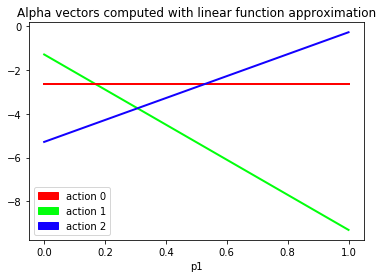

  [*] load ./experiments\pickle_jar\prob2_60.pkl
   [-] load_pkl : 0.00100 sec


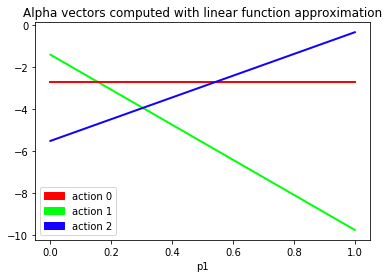

  [*] load ./experiments\pickle_jar\prob3_60.pkl
   [-] load_pkl : 0.00100 sec


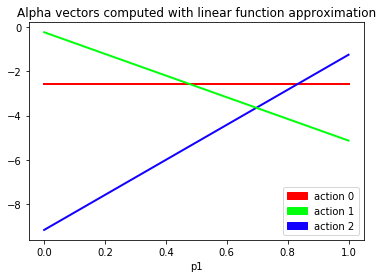

  [*] load ./experiments\pickle_jar\prob1_60.pkl
   [-] load_pkl : 0.00000 sec


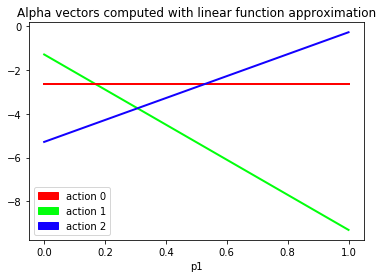

In [21]:
for prob in prob_fn:
    gamma = pickle_wrapper.load_pkl(os.path.join(weight_dir, prob+'.pkl'))

    plot_alpha_vectors.plot_alpha_vectors('Alpha vectors computed with linear function approximation', gamma, n_actions)

In [ ]:
collect = 